<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/master/notebooks/KD_DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Feb 14 21:56:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone -b develop-jose https://github.com/jmarrietar/Knowledge-Distillation-Zoo.git

Cloning into 'Knowledge-Distillation-Zoo'...
remote: Enumerating objects: 193, done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (193/193), 85.02 KiB | 5.00 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [3]:
cd Knowledge-Distillation-Zoo

/content/Knowledge-Distillation-Zoo


In [4]:
#!pip install cloud-tpu-client==0.10 torch==1.8.1 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl tensorboard-plugin-profile

In [5]:
#!pip uninstall torch -y
#!pip install torch==1.8.1

In [6]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division
import os
import sys
import time
import logging
import argparse
import numpy as np
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as dst
import torchvision

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

from google.colab import auth, drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

In [8]:
def accuracy(output, target, topk=(1,)):
	"""Computes the precision@k for the specified values of k"""
	maxk = max(topk)
	batch_size = target.size(0)

	_, pred = output.topk(maxk, 1, True, True)
	pred    = pred.t()
	correct = pred.eq(target.view(1, -1).expand_as(pred))

	res = []
	for k in topk:
		correct_k = correct[:k].view(-1).float().sum(0)
		res.append(correct_k.mul_(100.0 / batch_size))
	return res

In [9]:
from torchvision.transforms import transforms

In [10]:
class GaussianBlur(object):
    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.0):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        if torch.bernoulli(torch.tensor(self.prob)) == 0:
            return img

        radius = self.radius_min + torch.rand(1) * (self.radius_max - self.radius_min)
        return img.filter(ImageFilter.GaussianBlur(radius=radius))

In [11]:
# Mount Drive
drive.mount('/content/drive')
auth.authenticate_user()

Mounted at /content/drive


In [12]:
cd ..

/content


In [13]:
import gdown

def download(data, url):
    # Download dataset
    import zipfile
    url = url
    output = "{}.zip".format(data)
    gdown.download(url, output, quiet=False)

    # Uncompress dataset
    local_zip = '{}.zip'.format(data)
    zip_ref = zipfile.ZipFile(local_zip, "r")
    zip_ref.extractall()
    zip_ref.close()

In [14]:
def get_model_property(key):
  default_model_property = {
      'img_dim': 224,
      'model_fn': getattr(torchvision.models, FLAGS.model)
  }
  model_properties = {
      'inception_v3': {
          'img_dim': 299,
          'model_fn': lambda: torchvision.models.inception_v3(aux_logits=False)
      },
  }
  model_fn = model_properties.get(FLAGS.model, default_model_property)[key]
  return model_fn

In [15]:
"""
def adjust_lr_init(optimizer, epoch):
	scale   = 0.1
	lr_list = [args.lr*scale] * 30
	lr_list += [args.lr*scale*scale] * 10
	lr_list += [args.lr*scale*scale*scale] * 10

	lr = lr_list[epoch-1]
	logging.info('Epoch: {}  lr: {:.4f}'.format(epoch, lr))
	for param_group in optimizer.param_groups:
		param_group['lr'] = lr
"""

"\ndef adjust_lr_init(optimizer, epoch):\n\tscale   = 0.1\n\tlr_list = [args.lr*scale] * 30\n\tlr_list += [args.lr*scale*scale] * 10\n\tlr_list += [args.lr*scale*scale*scale] * 10\n\n\tlr = lr_list[epoch-1]\n\tlogging.info('Epoch: {}  lr: {:.4f}'.format(epoch, lr))\n\tfor param_group in optimizer.param_groups:\n\t\tparam_group['lr'] = lr\n"

In [16]:
data_samples = {
    "sample@200": "https://drive.google.com/uc?id=1FfV7YyDJvNUCDP5r3-8iQfZ2-xJp_pgb",
    "sample@500": "https://drive.google.com/uc?id=1dHwUqpmSogEdjAB9rwDUL-OKFRUcVXte",
    "sample@1000": "https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2",
    "sample@2000": "https://drive.google.com/uc?id=1PB7uGd-dUnZKnKZpZl-HvE1DVcWgX50F",
    "sample@3000": "https://drive.google.com/uc?id=1_yre5K9YYvJgSrT4xvrI8eD_htucIywA",
    "sample@4000_images": "https://drive.google.com/uc?id=1dqVB8EozEpwWzyuU80AauoQmsiw3Gtm2",
    "sample@20000": "https://drive.google.com/uc?id=1MTDpLzpmhSiZq2jSdmHx2UDPn9FC8gzO",
    "val-voets-tf": "https://drive.google.com/uc?id=1VzVgMGTkBBPG2qbzLunD9HvLzH6tcyrv",
    "train_voets": "https://drive.google.com/uc?id=1AmcFh1MOOZ6aqKm2eO7XEdgmIEqHKTZ5",
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd"
}

In [17]:
LABELED = 'sample@1000'

In [18]:
UNLABELED = 'train_voets'

In [20]:
URL_UNLABELED = data_samples[UNLABELED]
download(UNLABELED, URL_UNLABELED)

Downloading...
From: https://drive.google.com/uc?id=1AmcFh1MOOZ6aqKm2eO7XEdgmIEqHKTZ5
To: /content/train_voets.zip
100%|██████████| 3.09G/3.09G [00:14<00:00, 213MB/s]


In [21]:
!wget "https://raw.githubusercontent.com/pytorch/xla/master/test/args_parse.py"

--2022-02-14 22:01:00--  https://raw.githubusercontent.com/pytorch/xla/master/test/args_parse.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/plain]
Saving to: ‘args_parse.py’

args_parse.py       100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-02-14 22:01:00 (33.9 MB/s) - ‘args_parse.py’ saved [2036/2036]



In [22]:
import args_parse

SUPPORTED_MODELS = [
    'alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201',
    'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34',
    'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13',
    'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'
]

MODEL_OPTS = {
    '--model': {
        'choices': SUPPORTED_MODELS,
        'default': 'resnet50',
    },
    '--test_set_batch_size': {
        'type': int,
    },
    '--lr_scheduler_type': {
        'type': str,
    },
    '--lr_scheduler_divide_every_n_epochs': {
        'type': int,
    },
    '--lr_scheduler_divisor': {
        'type': int,
    },
    '--test_only_at_end': {
        'action': 'store_true',
    },
}

In [23]:
FLAGS = args_parse.parse_common_options(
    datadir=UNLABELED,
    batch_size=None,
    num_epochs=None,
    momentum=None,
    lr=None,
    target_accuracy=None,
    profiler_port=9012,
    opts=MODEL_OPTS.items(),
)

In [24]:
EPOCHS = 200

In [25]:
FLAGS.fake_data = False
FLAGS.num_epochs = EPOCHS
FLAGS.batch_size = 64
FLAGS.log_steps = 100
FLAGS.num_cores = 8

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
model1 = torchvision.models.densenet161(pretrained=True).to(device)

model1.classifier = nn.Sequential(
      nn.Linear(2208, 512),
      nn.Linear(512, 1),
      nn.Sigmoid()
  ).to(device)

In [28]:
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/SimCLR/models/SimCLR-1-DR-pytorch/net-DR-SimCLR-Finetuned-Test-{}.pt'.format(LABELED))

In [29]:
state_dict.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.wei

In [30]:
model2 = get_model_property('model_fn')().to(device)

model2.fc = nn.Sequential(
      nn.Linear(2048, 512),
      nn.Linear(512, 1),
      nn.Sigmoid()
  ).to(device)

In [31]:
log = model2.load_state_dict(state_dict, strict=False)
print(log)

<All keys matched successfully>


In [32]:
# Freeze Layers for Teacher 
for param in model2.parameters():
    param.requires_grad = False

In [33]:
parser = argparse.ArgumentParser(description='train kd')

# various path
parser.add_argument('--save_root', type=str, default='./results', help='models and logs are saved here')
parser.add_argument('--img_root', type=str, default='./datasets', help='path name of image dataset')
parser.add_argument('--s_init', type=str, required=True, help='initial parameters of student model')
parser.add_argument('--t_model', type=str, required=True, help='path name of teacher model')

# training hyper parameters
parser.add_argument('--print_freq', type=int, default=50, help='frequency of showing training results on console')
parser.add_argument('--epochs', type=int, default=200, help='number of total epochs to run')
parser.add_argument('--batch_size', type=int, default=128, help='The size of batch')
parser.add_argument('--lr', type=float, default=0.1, help='initial learning rate')
parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--weight_decay', type=float, default=1e-4, help='weight decay')
parser.add_argument('--num_class', type=int, default=10, help='number of classes')
parser.add_argument('--cuda', type=int, default=1)

# others
parser.add_argument('--seed', type=int, default=2, help='random seed')
parser.add_argument('--note', type=str, default='try', help='note for this run')

# net and dataset choosen
parser.add_argument('--data_name', type=str, required=True, help='name of dataset') # cifar10/cifar100
parser.add_argument('--t_name', type=str, required=True, help='name of teacher')    # resnet20/resnet110
parser.add_argument('--s_name', type=str, required=True, help='name of student')    # resnet20/resnet110

# hyperparameter
parser.add_argument('--kd_mode', type=str, required=True, help='mode of kd, which can be:'
															   'logits/st/at/fitnet/nst/pkt/fsp/rkd/ab/'
															   'sp/sobolev/cc/lwm/irg/vid/ofd/afd')
parser.add_argument('--lambda_kd', type=float, default=1.0, help='trade-off parameter for kd loss')
parser.add_argument('--T', type=float, default=4.0, help='temperature for ST')
parser.add_argument('--p', type=float, default=2.0, help='power for AT')
parser.add_argument('--w_dist', type=float, default=25.0, help='weight for RKD distance')
parser.add_argument('--w_angle', type=float, default=50.0, help='weight for RKD angle')
parser.add_argument('--m', type=float, default=2.0, help='margin for AB')
parser.add_argument('--gamma', type=float, default=0.4, help='gamma in Gaussian RBF for CC')
parser.add_argument('--P_order', type=int, default=2, help='P-order Taylor series of Gaussian RBF for CC')
parser.add_argument('--w_irg_vert', type=float, default=0.1, help='weight for IRG vertex')
parser.add_argument('--w_irg_edge', type=float, default=5.0, help='weight for IRG edge')
parser.add_argument('--w_irg_tran', type=float, default=5.0, help='weight for IRG transformation')
parser.add_argument('--sf', type=float, default=1.0, help='scale factor for VID, i.e. mid_channels = sf * out_channels')
parser.add_argument('--init_var', type=float, default=5.0, help='initial variance for VID')
parser.add_argument('--att_f', type=float, default=1.0, help='attention factor of mid_channels for AFD')


_StoreAction(option_strings=['--att_f'], dest='att_f', nargs=None, const=None, default=1.0, type=<class 'float'>, choices=None, help='attention factor of mid_channels for AFD', metavar=None)

In [34]:
args, unparsed = parser.parse_known_args(['--save_root', './results/logits/',
                                          '--t_model', './results/base/base-c10-r110/model_best.pth.tar',
                                          '--s_init', './results/base/base-c10-r20/initial_r20.pth.tar',
                                          '--data_name', 'DR',
                                          '--batch_size', '32',
                                          '--epochs', '30',
                                          '--t_name', 'resnet110', 
                                          '--s_name', 'resnet20',
                                          '--num_class', '2',
                                          '--kd_mode', 'logits', 
                                          '--note', 'logits-c10-r110-r20',
                                          '--print_freq', '30',
                                          '--lr', '0.0001', 
                                          ])

In [35]:
class Logits(nn.Module):
	'''
	Do Deep Nets Really Need to be Deep?
	http://papers.nips.cc/paper/5484-do-deep-nets-really-need-to-be-deep.pdf
	'''
	def __init__(self):
		super(Logits, self).__init__()

	def forward(self, out_s, out_t):
		loss = F.mse_loss(out_s, out_t)

		return loss

In [36]:
"""
def adjust_lr(optimizer, epoch):
	scale   = 0.1
	lr_list =  [args.lr] * 100
	lr_list += [args.lr*scale] * 50
	lr_list += [args.lr*scale*scale] * 50

	lr = lr_list[epoch-1]
	logging.info('Epoch: {}  lr: {:.3f}'.format(epoch, lr))
	for param_group in optimizer.param_groups:
		param_group['lr'] = lr
"""

"\ndef adjust_lr(optimizer, epoch):\n\tscale   = 0.1\n\tlr_list =  [args.lr] * 100\n\tlr_list += [args.lr*scale] * 50\n\tlr_list += [args.lr*scale*scale] * 50\n\n\tlr = lr_list[epoch-1]\n\tlogging.info('Epoch: {}  lr: {:.3f}'.format(epoch, lr))\n\tfor param_group in optimizer.param_groups:\n\t\tparam_group['lr'] = lr\n"

In [132]:
snet = model1

In [38]:
tnet = model2

In [39]:
for param in tnet.parameters():
  param.requires_grad = False

In [40]:
logging.info('Teacher: %s', tnet)
logging.info('-----------------------------------------------')

In [41]:
criterionKD = Logits()

In [42]:
criterionCls = torch.nn.BCELoss()

In [43]:
optimizer = torch.optim.SGD(snet.parameters(),
              lr = args.lr, 
              momentum = args.momentum, 
              weight_decay = args.weight_decay,
              nesterov = True)

In [44]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

In [45]:
"""
train_transform = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
  ])
"""

"\ntrain_transform = transforms.Compose([\n    transforms.Pad(4, padding_mode='reflect'),\n    transforms.RandomCrop(224),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=mean,std=std)\n  ])\n"

In [46]:
img_dim = get_model_property('img_dim')

In [47]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [48]:
s = 1
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s) # YO
train_dataset = torchvision.datasets.ImageFolder(
    #os.path.join(FLAGS.datadir, 'train'),
    os.path.join(FLAGS.datadir),
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([color_jitter], p=0.8), # YO
        transforms.RandomGrayscale(p=0.2),             # YO
        #GaussianBlur(),     # No me esta sirviendo + tengo dos versiones en el code base
        transforms.ToTensor(),
        #normalize, 
    ]))

In [49]:
# Define data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True)

In [50]:
# warp nets and criterions for train and test
nets = {'snet':snet, 'tnet':tnet}
criterions = {'criterionCls':criterionCls, 'criterionKD':criterionKD}

In [51]:
cd Knowledge-Distillation-Zoo

/content/Knowledge-Distillation-Zoo


In [52]:
from utils import AverageMeter, accuracy, transform_time
from utils import load_pretrained_model, save_checkpoint
from utils import create_exp_dir, count_parameters_in_MB

In [53]:
cd ..

/content


In [54]:
def train(train_loader, nets, optimizer, criterions, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    cls_losses = AverageMeter()
    kd_losses  = AverageMeter()
    top1       = AverageMeter()
    top5       = AverageMeter()

    snet = nets['snet']
    tnet = nets['tnet']

    criterionCls = criterions['criterionCls']
    criterionKD  = criterions['criterionKD']


    snet.train()

    if args.kd_mode in ['vid', 'ofd']:
        for i in range(1,4):
            criterionKD[i].train()

    end = time.time()

    for i, (img, target) in enumerate(train_loader, start=1):
        data_time.update(time.time() - end)

        if args.cuda:
            img = img.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

        if args.kd_mode in ['sobolev', 'lwm']:
            img.requires_grad = True

        out_s = snet(img)
        out_t = tnet(img)
        
        # probs to 0 - 1 YOOO
        out_t = (out_t>0.5).float()

        #target = target.unsqueeze(1)
        #target = target.to(torch.float32)

        cls_loss = 0 # YOOO
        #cls_loss = criterionCls(out_s, target)

        if args.kd_mode in ['logits', 'st']:
            #kd_loss = criterionKD(out_s, out_t.detach()) * args.lambda_kd
            kd_loss = criterionCls(out_s, out_t.detach()) # YOOOO

        loss = kd_loss # YOOO
        #loss = cls_loss + kd_loss

        prec1 = accuracy(out_s, target, topk=(1,))

        #cls_losses.update(cls_loss.item(), img.size(0))
        kd_losses.update(kd_loss.item(), img.size(0))
        top1.update(prec1[0].item(), img.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            log_str = ('Epoch[{0}]:[{1:03}/{2:03}] '
                        'Time:{batch_time.val:.4f} '
                        'Data:{data_time.val:.4f}  '
                        'Cls:{cls_losses.val:.4f}({cls_losses.avg:.4f})  '
                        'KD:{kd_losses.val:.4f}({kd_losses.avg:.4f})  '
                        'prec@1:{top1.val:.2f}({top1.avg:.2f})  '.format(
                        epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time,
                        cls_losses=cls_losses, kd_losses=kd_losses, top1=top1))
            logging.info(log_str)
            print(log_str)

In [55]:
"""
Idea: 
  - Comparar realizando Knowledge distillation solo de LABELED 1000 
  VS Knowledge distilattion de la UNLABELED 5000 (Solo el loss de consistency) + 
  despues un Finetuning de la Unlabeled
"""

'\nIdea: \n  - Comparar realizando Knowledge distillation solo de LABELED 1000 \n  VS Knowledge distilattion de la UNLABELED 5000 (Solo el loss de consistency) + \n  despues un Finetuning de la Unlabeled\n'

In [56]:
best_top1 = 0
for epoch in range(1, args.epochs+1):
  #adjust_lr(optimizer, epoch)

  # train one epoch
  epoch_start_time = time.time()
  train(train_loader, nets, optimizer, criterions, epoch)

  epoch_duration = time.time() - epoch_start_time
  logging.info('Epoch time: {}s'.format(int(epoch_duration)))
  print('Epoch time: {}s'.format(int(epoch_duration)))

  """
  # save model
  is_best = False
  if test_top1 > best_top1:
    best_top1 = test_top1
    is_best = True
  logging.info('Saving models......')
  save_checkpoint({
    'epoch': epoch,
    'snet': snet.state_dict(),
    'tnet': tnet.state_dict(),
    'prec@1': test_top1,
  }, is_best, args.save_root)
  """

Epoch[1]:[030/1776] Time:0.4804 Data:0.0008  Cls:0.0000(0.0000)  KD:0.6947(0.7016)  prec@1:84.38(71.88)  
Epoch[1]:[060/1776] Time:0.4845 Data:0.0010  Cls:0.0000(0.0000)  KD:0.6793(0.6970)  prec@1:78.12(71.51)  
Epoch[1]:[090/1776] Time:0.4679 Data:0.0002  Cls:0.0000(0.0000)  KD:0.6826(0.6935)  prec@1:84.38(72.33)  
Epoch[1]:[120/1776] Time:0.4722 Data:0.0002  Cls:0.0000(0.0000)  KD:0.6851(0.6915)  prec@1:43.75(72.58)  
Epoch[1]:[150/1776] Time:0.4698 Data:0.0002  Cls:0.0000(0.0000)  KD:0.6923(0.6889)  prec@1:78.12(72.25)  
Epoch[1]:[180/1776] Time:0.4676 Data:0.0002  Cls:0.0000(0.0000)  KD:0.6750(0.6868)  prec@1:53.12(72.07)  
Epoch[1]:[210/1776] Time:0.4660 Data:0.0002  Cls:0.0000(0.0000)  KD:0.6551(0.6839)  prec@1:75.00(71.88)  
Epoch[1]:[240/1776] Time:0.4725 Data:0.0002  Cls:0.0000(0.0000)  KD:0.6589(0.6816)  prec@1:75.00(71.67)  
Epoch[1]:[270/1776] Time:0.4756 Data:0.0002  Cls:0.0000(0.0000)  KD:0.6595(0.6794)  prec@1:78.12(71.78)  
Epoch[1]:[300/1776] Time:0.4695 Data:0.0002  C

In [ ]:
#TODO-SAVE MODEL: student. 

In [133]:
snet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

# Fine Tune Student 

In [62]:
URL_LABELED = data_samples[LABELED]
download(LABELED, URL_LABELED)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2 



FileNotFoundError: ignored

In [65]:
import zipfile

# Uncompress dataset
local_zip = 'sample@1000.zip'
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall()
zip_ref.close()

In [66]:
train_dataset_ft = torchvision.datasets.ImageFolder(
    os.path.join(LABELED, 'train'),
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

In [67]:
# Define data loader
train_loader_ft = torch.utils.data.DataLoader(
    train_dataset_ft,
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True)

In [68]:
def train_ft(train_loader, nets, optimizer, criterions, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    cls_losses = AverageMeter()
    kd_losses  = AverageMeter()
    top1       = AverageMeter()

    snet = nets['snet']

    criterionCls = criterions['criterionCls']
    criterionKD  = criterions['criterionKD']


    snet.train()

    if args.kd_mode in ['vid', 'ofd']:
        for i in range(1,4):
            criterionKD[i].train()

    end = time.time()

    for i, (img, target) in enumerate(train_loader, start=1):
        data_time.update(time.time() - end)

        if args.cuda:
            img = img.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

        if args.kd_mode in ['sobolev', 'lwm']:
            img.requires_grad = True

        out_s = snet(img)

        target = target.unsqueeze(1)
        target = target.to(torch.float32)

        cls_loss = criterionCls(out_s, target)

        loss = cls_loss # YOOO

        prec1 = accuracy(out_s, target, topk=(1,))

        cls_losses.update(cls_loss.item(), img.size(0))
        top1.update(prec1[0].item(), img.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            log_str = ('Epoch[{0}]:[{1:03}/{2:03}] '
                        'Time:{batch_time.val:.4f} '
                        'Data:{data_time.val:.4f}  '
                        'Cls:{cls_losses.val:.4f}({cls_losses.avg:.4f})  '
                        'prec@1:{top1.val:.2f}({top1.avg:.2f})  '.format(
                        epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time,
                        cls_losses=cls_losses, top1=top1))
            logging.info(log_str)
            print(log_str)

In [69]:
best_top1 = 0
for epoch in range(1, 100):
  #adjust_lr(optimizer, epoch)

  # train one epoch
  epoch_start_time = time.time()
  train_ft(train_loader_ft, nets, optimizer, criterions, epoch)

  epoch_duration = time.time() - epoch_start_time
  logging.info('Epoch time: {}s'.format(int(epoch_duration)))
  print('Epoch time: {}s'.format(int(epoch_duration)))

Epoch[1]:[030/032] Time:0.4132 Data:0.0001  Cls:0.4049(0.5618)  prec@1:43.75(49.79)  
Epoch time: 13s
Epoch[2]:[030/032] Time:0.4153 Data:0.0001  Cls:0.3444(0.5457)  prec@1:62.50(49.69)  
Epoch time: 13s
Epoch[3]:[030/032] Time:0.4132 Data:0.0001  Cls:0.4180(0.5544)  prec@1:56.25(50.73)  
Epoch time: 13s
Epoch[4]:[030/032] Time:0.4126 Data:0.0001  Cls:0.3352(0.5027)  prec@1:50.00(50.00)  
Epoch time: 13s
Epoch[5]:[030/032] Time:0.4144 Data:0.0002  Cls:0.4881(0.4641)  prec@1:59.38(50.10)  
Epoch time: 14s
Epoch[6]:[030/032] Time:0.4135 Data:0.0001  Cls:0.4833(0.4505)  prec@1:56.25(50.21)  
Epoch time: 13s
Epoch[7]:[030/032] Time:0.4167 Data:0.0002  Cls:0.5065(0.4572)  prec@1:43.75(50.21)  
Epoch time: 13s
Epoch[8]:[030/032] Time:0.4124 Data:0.0001  Cls:0.3985(0.4604)  prec@1:40.62(50.31)  
Epoch time: 13s
Epoch[9]:[030/032] Time:0.4136 Data:0.0001  Cls:0.2695(0.4457)  prec@1:43.75(50.31)  
Epoch time: 13s
Epoch[10]:[030/032] Time:0.4140 Data:0.0001  Cls:0.2927(0.4366)  prec@1:43.75(50.1

In [98]:
studen_file = "drive/MyDrive/Colab Notebooks/SimCLR/models/SimCLR-1-DR-pytorch/student.pt"

In [99]:
pwd

'/content'

In [100]:
# Save Student Model!

with open(studen_file, 'wb') as f:
    #torch.save(ema_model.state_dict(), f)
    torch.save(snet.state_dict(), f)

In [134]:
''' # Change Here
# Cambio que se Hace solo para sacar el Embedding 

snet.classifier = nn.Sequential(
    nn.Linear(2208, 512),  # Esto es un CAMBIO Para sacar el Embeddings volver a como estaba antes. 
    #nn.Linear(512, 1),
    #nn.Sigmoid()
).to(device)
'''

In [135]:
# Para cargar pesos previamente guardados
snet.load_state_dict(torch.load(studen_file), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['classifier.1.weight', 'classifier.1.bias'])

# Test

In [138]:
model = snet
#model = tnet

In [139]:
import zipfile
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [79]:
test_data = {
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd",
    "messidor2": "https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p",
}

TEST_DATASET = 'messidor2'
URL_TEST_DATASET = test_data[TEST_DATASET]

In [80]:
!gdown $URL_TEST_DATASET

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p 



In [81]:
local_zip = '{}.zip'.format(TEST_DATASET)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [82]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

In [83]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # What happens if I change This 
])

In [109]:
test_dataset = datasets.ImageFolder(root="messidor2", transform=transform_val) # root: test/messidor2

In [140]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False)

loader = test_loader

In [141]:
y_true = []
y_pred = []

with torch.no_grad():
    with tqdm(total=len(loader)) as pbar:
        for batch_idx, (inputs, targets) in enumerate(loader):

            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)

            output = output.to(device)

            # Yo le agrege esto
            y_true.append(targets.cpu().detach().numpy()[0])
            y_pred.append(output.cpu().detach().numpy()[0][0])

            pbar.update(1)

 13%|█▎        | 225/1748 [00:09<01:04, 23.44it/s]


KeyboardInterrupt: ignored

In [113]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.8730686365035396

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


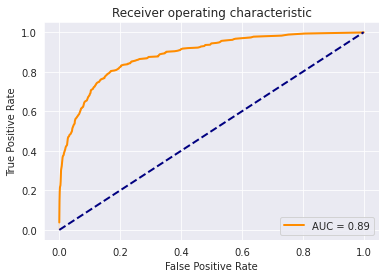

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
# %matplotlib inline

#cm=metrics.confusion_matrix(y_true, y_pred)
auc = metrics.auc(fpr, tpr)
#print('AUC: %.3f' % auc)
#print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

# Plot ROC curve
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax1 = sns.lineplot(fpr, tpr, color='darkorange',
        lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_title('Receiver operating characteristic')
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
############# Sacar Embeddings ##########

In [142]:
y_true = []
#y_pred = []
embeddings = []

with torch.no_grad():
    with tqdm(total=len(loader)) as pbar:
        for batch_idx, (inputs, targets) in enumerate(loader):

            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)

            #output = output.to(device)

            # Yo le agrege esto
            y_true.append(targets.cpu().detach().numpy()[0])
            #y_pred.append(output.cpu().detach().numpy()[0][0])
            embeddings.append(output.cpu().detach().numpy()[0])

            pbar.update(1)

100%|██████████| 1748/1748 [01:14<00:00, 23.61it/s]


In [143]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [144]:
len(y_true)
embeddings[0].shape

(512,)

In [145]:
embeddings = np.array(embeddings)

In [146]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap

def create_dataframe(y_pred_prob, y_true, dim_method):

    dimensionality_reduction = {
        "PCA": PCA(n_components=2),
        "TSNE": TSNE(n_components=2),
        #"UMAP": umap.UMAP(random_state=42),
    }

    method = dimensionality_reduction[dim_method]
    projected = method.fit_transform(y_pred_prob)
    dataset = pd.DataFrame(
        {"X": projected[:, 0], "Y": projected[:, 1], "class": y_true}
    )
    return dataset

In [147]:
ans = create_dataframe(embeddings, y_true, "TSNE")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [148]:
%matplotlib inline
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(12,10)})

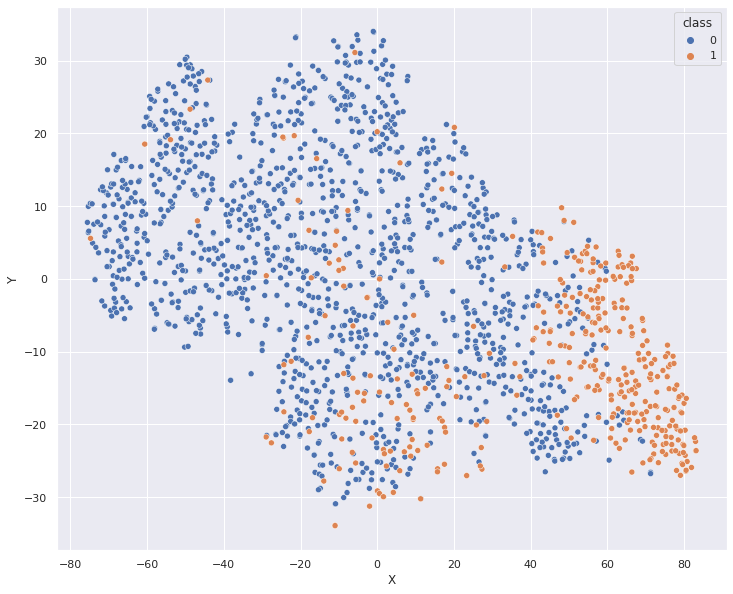

In [149]:
sns.scatterplot(data=ans, x="X", y="Y", hue="class")